In [1]:
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch
import torchvision
from fastai import *
from fastai.vision import *
import numpy as np


#processing tokens
import unicodedata 
import re
import inflect 

#tokenize
from nltk import word_tokenize, sent_tokenize

#find ngrams
from nltk.util import ngrams

import time
from tqdm import tqdm

#nn
import torch.nn as nn
from torch import optim
from sklearn import preprocessing

import arpa

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(torch.cuda.get_device_name(0))
print(torch.cuda.is_available())


GeForce GTX 1060 6GB
True


# load inputs from pickle file

### prefix count
### ngram count
### n-1gram count 
### unigram count

In [3]:
inputs = torch.load('../../pickles/train_input_8813319').transpose(-2,1).float()
outputs = torch.load('../../pickles/train_output_8813319').flatten().float()
inputs = 1/inputs
print(inputs)
print(outputs)

tensor([[1.6667e-01, 5.0000e-01, 1.6667e-01, 1.1641e-03],
        [1.2500e-01, 3.3333e-01, 1.3563e-04, 1.0103e-05],
        [1.2500e-01, 3.3333e-01, 8.7558e-05, 4.2129e-06],
        ...,
        [4.3478e-02, 1.6667e-01, 5.0000e-02, 6.0606e-03],
        [4.3478e-02, 5.0000e-01, 3.3333e-01, 1.6367e-03],
        [4.3478e-02, 3.3333e-01, 2.5000e-01, 2.8498e-04]], device='cuda:0')
tensor([0.2648, 0.2461, 0.2461,  ..., 0.2883, 0.0623, 0.1158], device='cuda:0')


In [4]:
if device.type == 'cuda':
    #print(torch.cuda.get_device_name(0))
    print('\nMemory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**2,1), 'MB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**2,1), 'MB')


Memory Usage:
Allocated: 168.5 MB
Cached:    444.0 MB


# Neural Net


In [5]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(4, 4)
        #self.fc2 = nn.Linear(4, 4)
        self.fc3 = nn.Linear(4, 3)
        self.fc4 = nn.Linear(3, 1)

        
    def forward(self, x):
        x = torch.sigmoid(self.fc1(x))
        #x = torch.sigmoid(self.fc2(x))
        x = torch.sigmoid(self.fc3(x)) 
        x = torch.sigmoid(self.fc4(x)) 
        return x
    
'''
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(3, 3)
        #self.fc2 = nn.Linear(4, 4)
        self.fc3 = nn.Linear(3, 3)
        self.fc4 = nn.Linear(3, 1)

        
    def forward(self, x):
        x = torch.sigmoid(self.fc1(x))
        #x = torch.sigmoid(self.fc2(x))
        x = torch.sigmoid(self.fc3(x)) 
        x = torch.sigmoid(self.fc4(x)) 
        return x
'''

'\nclass Net(nn.Module):\n    def __init__(self):\n        super(Net, self).__init__()\n        self.fc1 = nn.Linear(3, 3)\n        #self.fc2 = nn.Linear(4, 4)\n        self.fc3 = nn.Linear(3, 3)\n        self.fc4 = nn.Linear(3, 1)\n\n        \n    def forward(self, x):\n        x = torch.sigmoid(self.fc1(x))\n        #x = torch.sigmoid(self.fc2(x))\n        x = torch.sigmoid(self.fc3(x)) \n        x = torch.sigmoid(self.fc4(x)) \n        return x\n'

# Train

In [65]:
net = Net().cuda()
optimizer = optim.SGD(net.parameters(), lr=0.03, momentum=0.9)
#criterion = torch.nn.SmoothL1Loss()  
criterion = torch.nn.L1Loss()  #mean absolute error
#criterion = torch.nn.MSELoss()  #mean square error


In [67]:
start = time.time()

## run the model for 7 epochs
for epoch in range(0,3):
    for x in tqdm(range(len(inputs)),position=0, leave=True): #x starts at zero
        #if x % 15 == 1 : #skip over some entries
        optimizer.zero_grad()

        #ins = torch.tensor([[inputs[x:x+1,0]/inputs[x:x+1,1],inputs[x:x+1,2],inputs[x:x+1,3]]], device = device)

        ## 1. forward propagation
        net_out = net((inputs[x:x+1,:]))
        #net_out = net(ins)
        #print(train[:,x:(x+1)])

        ## 2. loss calculation
        loss = criterion(net_out, outputs[x].reshape(1,1))
        #print(target[x])

        ## 3. backward propagation
        loss.backward()

        ## 4. weight optimization
        optimizer.step()

        #if(x % 10000 == 1):
        #    print('Loss: {:.6f}'.format(loss.data))

        
end = time.time()
print(end-start)

100%|██████████| 8813319/8813319 [3:20:51<00:00, 731.29it/s]  

35980.39104318619


# Saving Model

In [73]:
torch.save(net.state_dict(), 'NN saves/4431_lr=0.03_')

# Loading model

In [8]:
net = Net().cuda()
net.load_state_dict(torch.load('NN saves/mse_4431_lr=0.01_m=0.9_without_r=1'))
net.eval()

Net(
  (fc1): Linear(in_features=4, out_features=4, bias=True)
  (fc3): Linear(in_features=4, out_features=3, bias=True)
  (fc4): Linear(in_features=3, out_features=1, bias=True)
)

# Comparing: 
## done on dev set - tbd

In [51]:
'''
inputs = torch.load('../../pickles/train_input_8813319').transpose(-2,1).float()
outputs = torch.load('../../pickles/train_output_8813319').flatten().float()
inputs = 1/inputs
'''

"\ninputs = torch.load('../../pickles/train_input_8813319').transpose(-2,1).float()\noutputs = torch.load('../../pickles/train_output_8813319').flatten().float()\ninputs = 1/inputs\n"

In [70]:
difference = np.zeros(int(len(inputs)/10)+1)
net_results = np.zeros(int(len(inputs)/10)+1)
actual_results = np.zeros(int(len(inputs)/10)+1)
count = 0

for x in tqdm(range(len(inputs)),position=0, leave=True):
    if x%10 == 1:
        net_results[count] = net(inputs[x:x+1,:])
        #ins = torch.tensor([[inputs[x:x+1,0]/inputs[x:x+1,1],inputs[x:x+1,2],inputs[x:x+1,3]]], device = device)
        #net_results[count] = net(ins)
        actual_results[count] = outputs[x]
        difference[count] = abs(net_results[count] - actual_results[count])
        count += 1

net_results.sort()
actual_results.sort()
difference.sort()

100%|██████████| 8813319/8813319 [03:33<00:00, 41298.28it/s]


# 4431
## lr=0.03 m=0.9 MAE - 3 full epochs

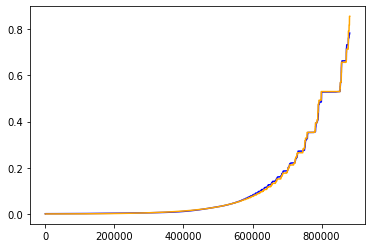

In [71]:
plt.plot(net_results,'b')
plt.plot(actual_results,'orange')
plt.show()

In [72]:
print(net_results)
print(actual_results)

[5.062454e-04 7.131235e-04 7.167892e-04 7.186914e-04 ... 7.823949e-01 7.825264e-01 7.825924e-01 7.828616e-01]
[1.469640e-06 1.469640e-06 1.469640e-06 1.469640e-06 ... 8.557763e-01 8.557763e-01 8.557763e-01 8.557763e-01]


# 4431
## lr=0.005 m=0.9 MAE

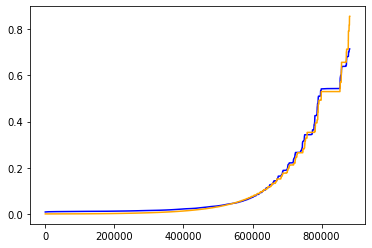

In [63]:
plt.plot(net_results,'b')
plt.plot(actual_results,'orange')
plt.show()

In [64]:
print(net_results)
print(actual_results)

[0.008385 0.008387 0.008387 0.008387 ... 0.71391  0.714112 0.714144 0.714197]
[1.469640e-06 1.469640e-06 1.469640e-06 1.469640e-06 ... 8.557763e-01 8.557763e-01 8.557763e-01 8.557763e-01]


## lr=0.1 m=0.9 MAE - longer epochs significantly improve output

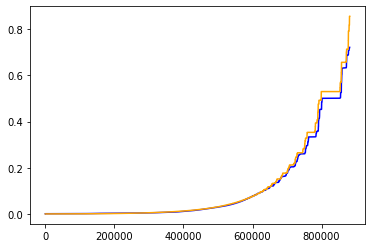

In [53]:
plt.plot(net_results,'b')
plt.plot(actual_results,'orange')
plt.show()

In [54]:
print(net_results)
print(actual_results)

[3.689162e-04 6.072581e-04 6.102683e-04 6.118314e-04 ... 7.207626e-01 7.208312e-01 7.208709e-01 7.209401e-01]
[1.469640e-06 1.469640e-06 1.469640e-06 1.469640e-06 ... 8.557763e-01 8.557763e-01 8.557763e-01 8.557763e-01]


## lr=0.1 m=0.9 MSE

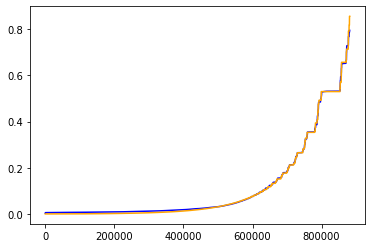

In [64]:
plt.plot(net_results,'b')
plt.plot(actual_results,'orange')
plt.show()

## lr=0.05 m=0.5 MSE

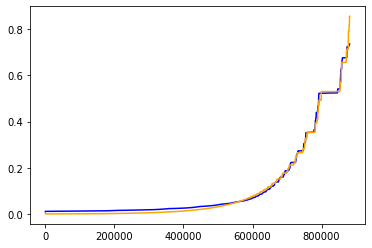

In [86]:
plt.plot(net_results,'b')
plt.plot(actual_results,'orange')
plt.show()

## lr=0.3 m=0.9 MSE

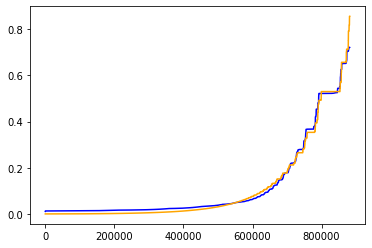

In [80]:
plt.plot(net_results,'b')
plt.plot(actual_results,'orange')
plt.show()

## lr=0.1 m=0.1 MSE

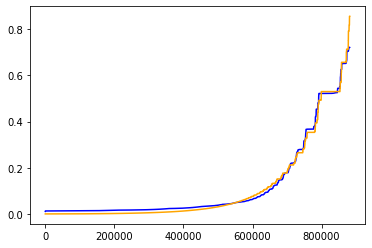

In [75]:
plt.plot(net_results,'b')
plt.plot(actual_results,'orange')
plt.show()

## lr=0.03 m=0.9 MSE

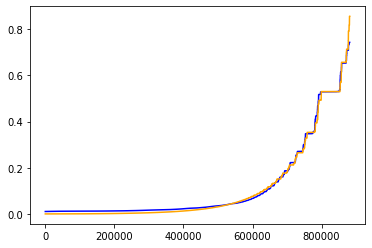

In [49]:
plt.plot(net_results,'b')
plt.plot(actual_results,'orange')
plt.show()

## lr=0.01 m=0.9 MSE

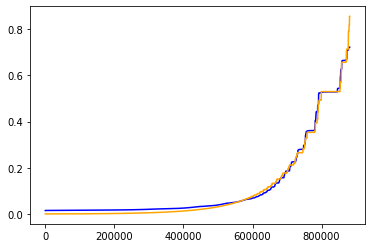

In [39]:
plt.plot(net_results,'b')
plt.plot(actual_results,'orange')
plt.show()

## lr=0.005 m=0.7 MSE

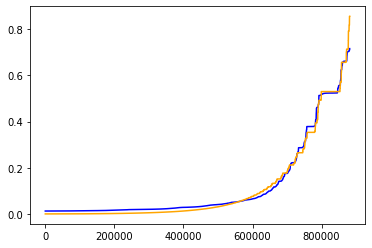

In [29]:
plt.plot(net_results,'b')
plt.plot(actual_results,'orange')
plt.show()

## lr=0.003 m=0.9 MSE

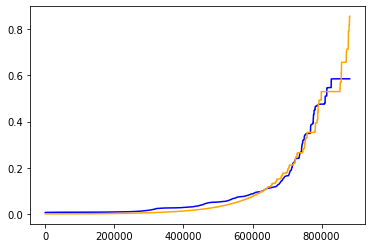

In [24]:
plt.plot(net_results,'b')
plt.plot(actual_results,'orange')
plt.show()

## lr=0.001 m=0.9 MSE

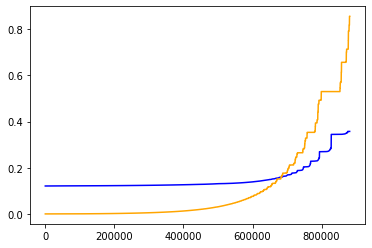

In [19]:
plt.plot(net_results,'b')
plt.plot(actual_results,'orange')
plt.show()

## lr=0.1 m=0.1 MSE

# 3331
## 9 epochs

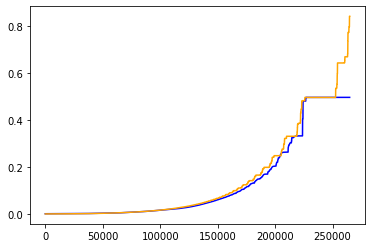

In [11]:
plt.plot(net_results,'b')
plt.plot(actual_results,'orange')
plt.show()

In [12]:
print(net_results)
print(actual_results)

[0.000752 0.000752 0.000752 0.000752 ... 0.496927 0.496927 0.496927 0.496927]
[5.888951e-06 5.888951e-06 5.888951e-06 5.888951e-06 ... 8.428460e-01 8.428460e-01 8.428460e-01 8.428460e-01]


## 1 epoch

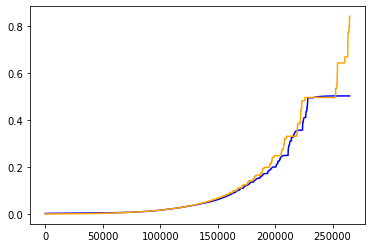

In [120]:
plt.plot(net_results,'b')
plt.plot(actual_results,'orange')
plt.show()

In [121]:
print(net_results)
print(actual_results)

[0.002008 0.002009 0.002009 0.002009 ... 0.503047 0.503047 0.503047 0.503047]
[5.888951e-06 5.888951e-06 5.888951e-06 5.888951e-06 ... 8.428460e-01 8.428460e-01 8.428460e-01 8.428460e-01]


# 4431
## lr = 0.001

# m = 0.5

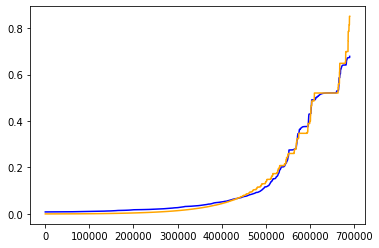

In [231]:
plt.plot(net_results,'b')
plt.plot(actual_results,'orange')
plt.show()

# m = 0.1

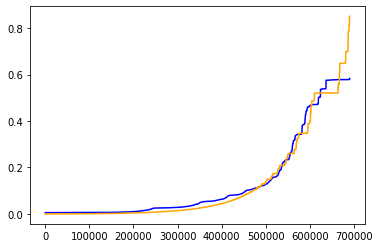

In [224]:
plt.plot(net_results,'b')
plt.plot(actual_results,'orange')
plt.show()

# m = 0.9

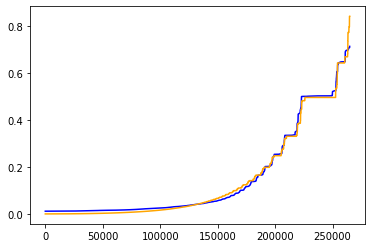

In [21]:
plt.plot(net_results,'b')
plt.plot(actual_results,'orange')
plt.show()

# lets adjust results to account improve accuracy

In [42]:
print(actual_results[0])
print(net_results[0])
print(actual_results[0] - net_results[0])

1.469640096729563e-06
0.0002562386798672378
-0.00025476903977050824


In [44]:
scaled_results = net_results + (actual_results[0] - net_results[0])
print(scaled_results)

[1.469640e-06 4.867213e-04 4.900129e-04 4.917183e-04 ... 6.784951e-01 6.784960e-01 6.785060e-01 6.787194e-01]


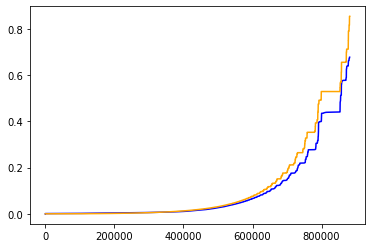

In [30]:
plt.plot(scaled_results,'b')
plt.plot(actual_results,'orange')
plt.show()

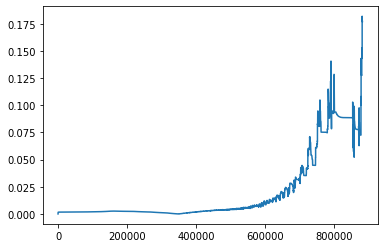

In [16]:
plt.plot(abs(scaled_results-actual_results))
#plt.plot(difference)
plt.show()

# Visualising $P_{MLE}$ vs $P_{LM}$ vs $P_{NN}$


In [75]:
difference = np.zeros(int(len(inputs)/10)+1)
MLE = np.zeros(int(len(inputs)/10)+1)
PLM = np.zeros(int(len(inputs)/10)+1)
count = 0

for x in tqdm(range(len(inputs)),position=0, leave=True):
    if x%10 == 1:
        MLE[count] = inputs[x,0]/inputs[x,1]
        PLM[count] = outputs[x]
        difference[count] = abs(MLE[count] - PLM[count])
        count += 1

MLE.sort()
PLM.sort()
difference.sort()
#print(MLE)
#print(PLM)

100%|██████████| 8813319/8813319 [00:58<00:00, 151458.36it/s]


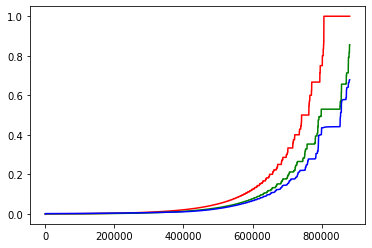

In [31]:
plt.plot(MLE , 'r')
plt.plot(PLM, 'g')
#plt.plot(net_results, 'b')
plt.plot(scaled_results, 'blue')
plt.show()

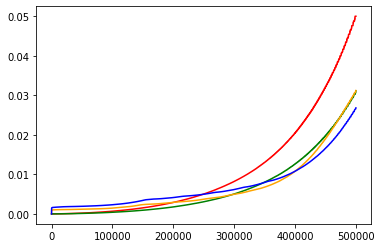

In [77]:
plt.plot(MLE[:500000] , 'r')
plt.plot(PLM[:500000], 'g')
plt.plot(net_results[:500000], 'orange')
plt.plot(scaled_results[:500000], 'blue')
plt.show()

In [46]:
print(PLM[0])
print(scaled_results[0])

1.469640096729563e-06
1.469640096729563e-06
